In [1]:
#Importamos las librerias necesarias
import os  
import pandas as pd
import numpy as np
import json
import unicodedata
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

In [2]:
#Cargamos los datos desde los archivos
cards_data = pd.read_csv('cards_data.csv')
transactions_data = pd.read_csv('transactions_data.csv')
users_data = pd.read_csv('users_data.csv')
#mcc_codes = pd.read_csv('mcc_codes.json')
#train_fraud_labels =  pd.read_csv('train_fraud_labels.json')

In [3]:
#Pasamos los archivos json a un formato de dataframe

# 1. Abrir el archivo JSON
with open("mcc_codes.json", "r", encoding="utf-8") as f:
    mcc_dict = json.load(f)

# 2. Convertir el diccionario a una lista de tuplas y luego a DataFrame
rows = []
for code_str, desc in mcc_dict.items():
    # Si prefieres que el código mcc sea entero, puedes hacer: int(code_str)
    rows.append({
        "mcc": int(code_str),               # convierte "5812" → 5812
        "mcc_description": desc             # por ejemplo, "Eating Places and Restaurants"
    })

mcc_codes_df = pd.DataFrame(rows)

# 3. (Opcional) Ordenar por código
mcc_codes_df = mcc_codes_df.sort_values("mcc").reset_index(drop=True)

# 4. Ver resultado
print(mcc_codes_df.shape)
print(mcc_codes_df.head(10))

(109, 2)
    mcc                                  mcc_description
0  1711  Heating, Plumbing, Air Conditioning Contractors
1  3000                                       Steelworks
2  3001                     Steel Products Manufacturing
3  3005                  Miscellaneous Metal Fabrication
4  3006          Miscellaneous Fabricated Metal Products
5  3007                    Coated and Laminated Products
6  3008                          Steel Drums and Barrels
7  3009             Fabricated Structural Metal Products
8  3058             Tools, Parts, Supplies Manufacturing
9  3066                             Miscellaneous Metals


In [4]:
# 1. Abrir el JSON
with open("train_fraud_labels.json", "r", encoding="utf-8") as f:
    labels_dict = json.load(f)


# 2. Extraer el diccionario interno que está bajo la clave "target"
inner = labels_dict["target"]

# 3. Convertir ese sub-diccionario a lista de filas
rows = []
for id_str, label_str in inner.items():
    rows.append({
        "id": int(id_str),               # convierte "10649266" → 10649266
        "is_fraud": 1 if label_str.lower() == "yes" else 0
    })

fraud_labels_df = pd.DataFrame(rows)

# 4. (Opcional) Ordenar por 'id'
fraud_labels_df = fraud_labels_df.sort_values("id").reset_index(drop=True)

# 5. Ver resultado
print(fraud_labels_df.shape)
print(fraud_labels_df.head(10))


(8914963, 2)
        id  is_fraud
0  7475327         0
1  7475328         0
2  7475329         0
3  7475332         0
4  7475333         0
5  7475335         0
6  7475338         0
7  7475339         0
8  7475340         0
9  7475341         0


# ------------------------------------------
# 1. Cargar datos de cards_data.csv
# ------------------------------------------

In [5]:
#Inspección inicial de los datos cards_data
print("Dimensiones iniciales de 'transactions':", cards_data.shape)
print(cards_data.dtypes)
print(cards_data.head(10))

Dimensiones iniciales de 'transactions': (6146, 13)
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object
     id  client_id  card_brand        card_type       card_number  expires  \
0  4524        825        Visa            Debit  4344676511950444  12/2022   
1  2731        825        Visa            Debit  4956965974959986  12/2020   
2  3701        825        Visa            Debit  4582313478255491  02/2024   
3    42        825        Visa           Credit  4879494103069057  08/2024   
4  4659        825  Mastercard  Debit (Prepaid)  5722874738736011  03/2009   
5  4537       1746        Visa           Credit  4

# ------------------------------------------
# 2. Visualización inicial de los datos
# ------------------------------------------

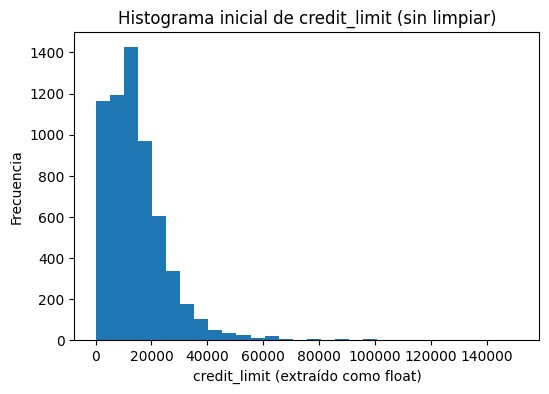

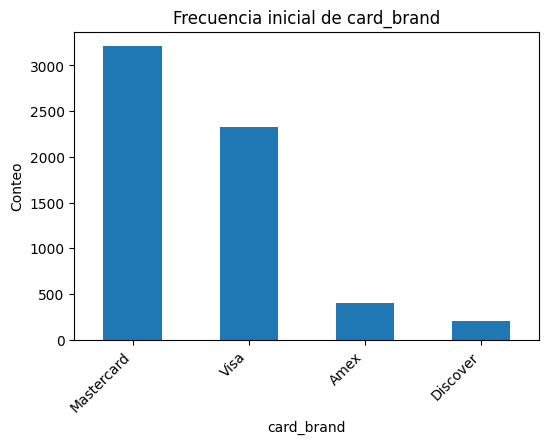

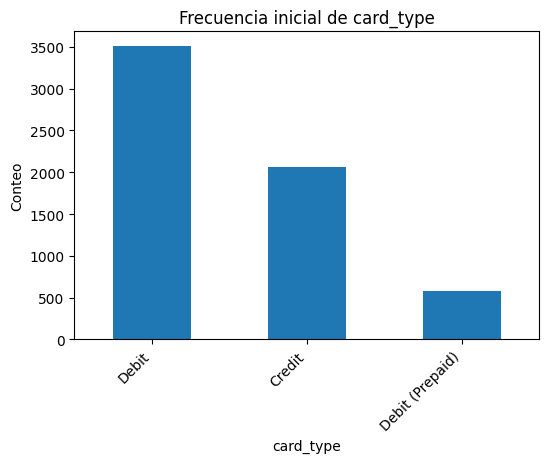

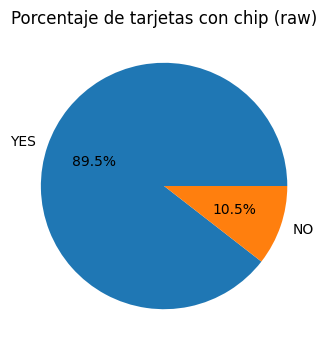

In [6]:
# 2.1 Distribución de credit_limit (raw, como texto)
# Extraer solo valores numéricos de credit_limit antes de limpiar
raw_credit = (
    cards_data["credit_limit"]
    .astype(str)
    .str.replace(r"[^\d\.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)

plt.figure(figsize=(6, 4))
plt.hist(raw_credit.dropna(), bins=30)
plt.title("Histograma inicial de credit_limit (sin limpiar)")
plt.xlabel("credit_limit (extraído como float)")
plt.ylabel("Frecuencia")
plt.show()

# 2.2 Conteo de card_brand (raw, valores crudos)
plt.figure(figsize=(6, 4))
cards_data["card_brand"].value_counts().plot(kind="bar")
plt.title("Frecuencia inicial de card_brand")
plt.xlabel("card_brand")
plt.ylabel("Conteo")
plt.xticks(rotation=45, ha='right')
plt.show()

# 2.3 Conteo de card_type (raw)
plt.figure(figsize=(6, 4))
cards_data["card_type"].value_counts().plot(kind="bar")
plt.title("Frecuencia inicial de card_type")
plt.xlabel("card_type")
plt.ylabel("Conteo")
plt.xticks(rotation=45, ha='right')
plt.show()

# 2.4 Proporción de tarjetas con chip vs sin chip (raw)
plt.figure(figsize=(4, 4))
cards_data["has_chip"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Porcentaje de tarjetas con chip (raw)")
plt.ylabel("")  # Ocultar etiqueta y-axis
plt.show()

# ------------------------------------------
# 3. Limpieza de los datos card data
# ------------------------------------------

In [7]:


# 2.1) Renombrar 'id' a 'card_id'
cards_data = cards_data.rename(columns={"id": "card_id"})

# 2.2) Convertir 'expires' y 'acct_open_date' de "MM/YYYY" a datetime (fin de mes)
cards_data["expires"] = (
    pd.to_datetime(cards_data["expires"], format="%m/%Y", errors="coerce")
    + pd.offsets.MonthEnd(0)
)
cards_data["acct_open_date"] = (
    pd.to_datetime(cards_data["acct_open_date"], format="%m/%Y", errors="coerce")
    + pd.offsets.MonthEnd(0)
)

# 2.3) Limpiar y convertir 'credit_limit' a float
cards_data["credit_limit"] = (
    cards_data["credit_limit"]
    .astype(str)
    .str.replace(r"[^\d\.]", "", regex=True)  # quita todo excepto dígitos y punto
    .replace("", np.nan)
    .astype(float)
)

# 2.4) Mapear 'has_chip' y 'card_on_dark_web' a binario 1/0
cards_data["has_chip"] = cards_data["has_chip"].str.strip().str.upper().map({"YES": 1, "NO": 0})
cards_data["card_on_dark_web"] = cards_data["card_on_dark_web"].str.strip().str.lower().map({"yes": 1, "no": 0})

# 2.5) Función para normalizar texto (minúsculas + quitar acentos)
def normalize_text(col):
    col = col.str.lower().str.strip()
    return col.apply(
        lambda x: unicodedata.normalize("NFKD", x)
                    .encode("ascii", errors="ignore")
                    .decode("utf-8")
        if isinstance(x, str) else x
    )

cards_data["card_brand"] = normalize_text(cards_data["card_brand"].astype(str))
cards_data["card_type"]  = normalize_text(cards_data["card_type"].astype(str))

# 2.6) Convertir 'card_number' y 'cvv' a string
cards_data["card_number"] = cards_data["card_number"].astype(str)
cards_data["cvv"]         = cards_data["cvv"].astype(str)

# 2.7) Verificar nulos tras limpieza
print("Nulos en cards_data tras limpieza:")
display(cards_data.isnull().sum())

# 2.8) One-Hot Encoding para 'card_brand' y 'card_type' (opcional)
cards_encoded = pd.get_dummies(
    cards_data,
    columns=["card_brand", "card_type"],
    drop_first=True
)
print("Dimensiones tras One-Hot Encoding de tarjetas:", cards_encoded.shape)
print("Ejemplo de columnas codificadas de tarjeta:", 
      [c for c in cards_encoded.columns if c.startswith("card_brand_") or c.startswith("card_type_")][:5])


Nulos en cards_data tras limpieza:


card_id                  0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

Dimensiones tras One-Hot Encoding de tarjetas: (6146, 16)
Ejemplo de columnas codificadas de tarjeta: ['card_brand_discover', 'card_brand_mastercard', 'card_brand_visa', 'card_type_debit', 'card_type_debit (prepaid)']


# ------------------------------------------
# 1. Cargar datos de transactions_data.csv
# ------------------------------------------

In [8]:
#Inspección inicial de los datos transactions_data
print("Dimensiones iniciales de 'transactions':", transactions_data.shape)
print(transactions_data.dtypes)
print(transactions_data.head(10))

Dimensiones iniciales de 'transactions': (13305915, 12)
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object
        id                 date  client_id  card_id   amount  \
0  7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1  7475328  2010-01-01 00:02:00        561     4575   $14.57   
2  7475329  2010-01-01 00:02:00       1129      102   $80.00   
3  7475331  2010-01-01 00:05:00        430     2860  $200.00   
4  7475332  2010-01-01 00:06:00        848     3915   $46.41   
5  7475333  2010-01-01 00:07:00       1807      165    $4.81   
6  7475334  2010-01-01 00:09:00       1556     2972   $77.00   
7  7475335  2010-01-01 00:14:00       1684     2140   $26.46   
8  7475336  2010-01-01 00:21:00        335

# ------------------------------------------
# 2. Visualización inicial de los datos
# ------------------------------------------

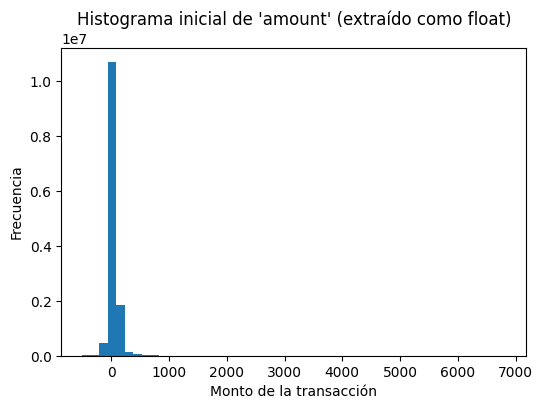

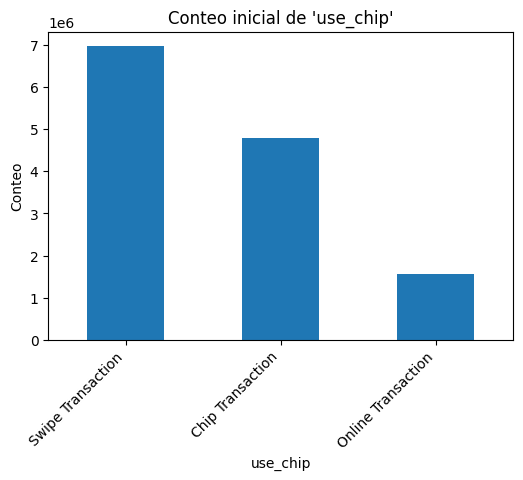

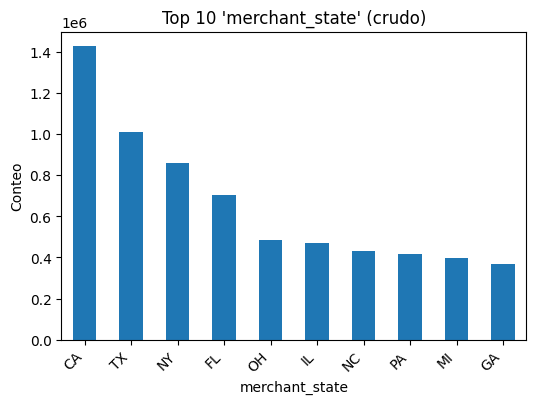

Número total de filas: 13305915
Filas con 'zip' = NaN: 1652706 (12.42%)

Ejemplos (hasta 5 filas) con 'merchant_state' faltante:


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
7,7475335,2010-01-01 00:14:00,1684,2140,$26.46,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
8,7475336,2010-01-01 00:21:00,335,5131,$261.58,Online Transaction,50292,ONLINE,NaN,NaN,7801,NaN
18,7475346,2010-01-01 00:34:00,394,4717,$26.04,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
24,7475353,2010-01-01 00:43:00,301,3742,$10.17,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
26,7475356,2010-01-01 00:45:00,566,3439,$16.86,Online Transaction,16798,ONLINE,NaN,NaN,4121,NaN


In [9]:
# 2.1 Histograma de 'amount' (sin convertir a float todavía)
#     Extraemos los valores numéricos para visualizar su distribución.
raw_amount = (
    transactions_data["amount"]
    .astype(str)
    .str.replace(r"[^\d\-\.\d]", "", regex=True)   # Dejamos dígitos, guión (negativo) y punto
    .replace("", np.nan)
    .astype(float)
)

plt.figure(figsize=(6, 4))
plt.hist(raw_amount.dropna(), bins=50)
plt.title("Histograma inicial de 'amount' (extraído como float)")
plt.xlabel("Monto de la transacción")
plt.ylabel("Frecuencia")
plt.show()


# 2.2 Conteo de 'use_chip' (crudo)
plt.figure(figsize=(6,4))
transactions_data["use_chip"].value_counts().plot(kind="bar")
plt.title("Conteo inicial de 'use_chip'")
plt.xlabel("use_chip")
plt.ylabel("Conteo")
plt.xticks(rotation=45, ha="right")
plt.show()


# 2.3 Conteo de 'merchant_state' (crudo)
plt.figure(figsize=(6,4))
# Mostramos solo las 10 estados más frecuentes para no abarrotar la gráfica
transactions_data["merchant_state"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 'merchant_state' (crudo)")
plt.xlabel("merchant_state")
plt.ylabel("Conteo")
plt.xticks(rotation=45, ha="right")
plt.show()


# 2.4 Porcentaje de filas con 'zip' faltante
n_total = len(transactions_data)
n_zip_na = transactions_data["zip"].isnull().sum()
print(f"Número total de filas: {n_total}")
print(f"Filas con 'zip' = NaN: {n_zip_na} ({100 * n_zip_na/n_total:.2f}%)")


# Opcional: muestra ejemplo de filas con 'merchant_state' = NaN
print("\nEjemplos (hasta 5 filas) con 'merchant_state' faltante:")
display(transactions_data[transactions_data["merchant_state"].isnull()].head(5))

# ------------------------------------------
# 3. Limpieza de los datos transactions_data
# ------------------------------------------

In [10]:
# 3.1 Convertir 'date' a datetime
transactions_data["date"] = pd.to_datetime(
    transactions_data["date"], format="%Y-%m-%d %H:%M:%S", errors="coerce"
)

# 3.2 Convertir 'amount' a float (quitando símbolos)
transactions_data["amount"] = (
    transactions_data["amount"]
    .astype(str)
    .str.replace(r"[^\d\-\.\d]", "", regex=True)   # Dígitos, guión y punto
    .replace("", np.nan)
    .astype(float)
)

# 3.3 Normalizar 'use_chip' (a minúsculas y recortar espacios)
transactions_data["use_chip"] = (
    transactions_data["use_chip"]
    .astype(str)
    .str.lower()
    .str.strip()
)

# 3.4 Normalizar 'merchant_city' y 'merchant_state', rellenar NaN
def normalize_text(col):
    col = col.str.lower().str.strip()
    col = col.apply(lambda x: unicodedata.normalize("NFKD", x)
                    .encode("ascii", errors="ignore")
                    .decode("utf-8")
                    if isinstance(x, str) else x)
    return col

transactions_data["merchant_city"] = normalize_text(
    transactions_data["merchant_city"].fillna("unknown")
)
transactions_data["merchant_state"] = normalize_text(
    transactions_data["merchant_state"].fillna("unknown")
)

# 3.5 Convertir 'zip' de float a string de 5 dígitos, rellena NaN con "00000"
transactions_data["zip"] = (
    transactions_data["zip"]
    .fillna(0)
    .astype(int)
    .astype(str)
    .str.zfill(5)
)

# 3.6 Tratar la columna 'errors': rellenar NaN con "no_error" y normalizar texto
transactions_data["errors"] = normalize_text(
    transactions_data["errors"].fillna("no_error")
)

# 3.7 Convertir el resto de identificadores a str (opcionalmente)
#     (Puede ayudar a no mezclar tipos al hacer merges)
transactions_data["id"] = transactions_data["id"].astype(str)
transactions_data["client_id"] = transactions_data["client_id"].astype(str)
transactions_data["card_id"] = transactions_data["card_id"].astype(str)
transactions_data["merchant_id"] = transactions_data["merchant_id"].astype(str)
transactions_data["mcc"] = transactions_data["mcc"].astype(str)

# 3.8 Revisar valores faltantes tras limpieza
print("\nValores faltantes en 'transactions' tras limpieza:")
display(transactions_data.isnull().sum())

# 3.9 Detectar y eliminar duplicados basados en 'id'
dup_count = transactions_data.duplicated(subset=["id"], keep=False).sum()
print(f"\nNúmero de transacciones duplicadas por 'id': {dup_count}")
transactions = transactions_data.drop_duplicates(subset=["id"], keep="first")

# 3.10 Extraer variables temporales desde 'date'
transactions["trans_hour"] = transactions["date"].dt.hour
transactions["trans_day"] = transactions["date"].dt.day
transactions["trans_month"] = transactions["date"].dt.month
transactions["trans_weekday"] = transactions["date"].dt.weekday

# 3.11 One-Hot Encoding para columnas categóricas (si las vas a usar en un modelo)
#      Por ejemplo: 'use_chip', 'merchant_state'
cat_cols = ["use_chip", "merchant_state"]
transactions_encoded = pd.get_dummies(
    transactions,
    columns=cat_cols,
    drop_first=True
)

# 3.12 (Opcional) Si quieres codificar 'mcc' como entero y unir con mcc_codes_df
#      Primero convierte a entero:
# transactions["mcc"] = transactions["mcc"].astype(int)
#      Luego haz merge con el DataFrame mcc_codes_df que creaste antes:
# transactions = transactions.merge(mcc_codes_df, on="mcc", how="left")

# 3.13 Ver dimensiones tras la codificación
print("\nDimensiones tras One-Hot Encoding y limpieza:")
print(transactions_encoded.shape)


Valores faltantes en 'transactions' tras limpieza:


id                0
date              0
client_id         0
card_id           0
amount            0
use_chip          0
merchant_id       0
merchant_city     0
merchant_state    0
zip               0
mcc               0
errors            0
dtype: int64


Número de transacciones duplicadas por 'id': 0

Dimensiones tras One-Hot Encoding y limpieza:
(13305915, 215)


# ------------------------------------------
# 1. Cargar datos de users_data.csv
# ------------------------------------------

In [11]:
#Inspección inicial de los datos users_data
print("Dimensiones iniciales de 'transactions':", users_data.shape)
print(users_data.dtypes)
print(users_data.head(10))

Dimensiones iniciales de 'transactions': (2000, 14)
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object
     id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   
3   708           63              63        1957            1  Female   
4  1164           43              70        1976            9    Male   
5    68           42              70        1977           10    Male   
6  1075          

# ------------------------------------------
# 2. Visualización inicial de los datos
# ------------------------------------------

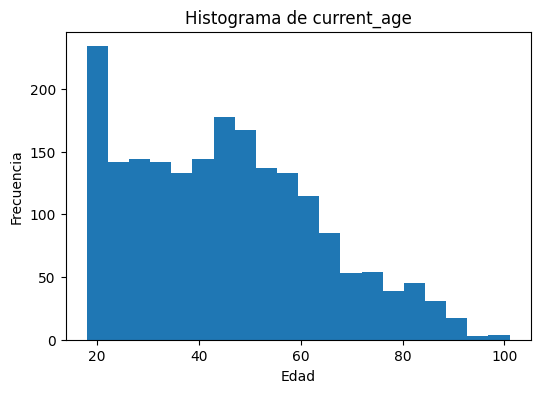

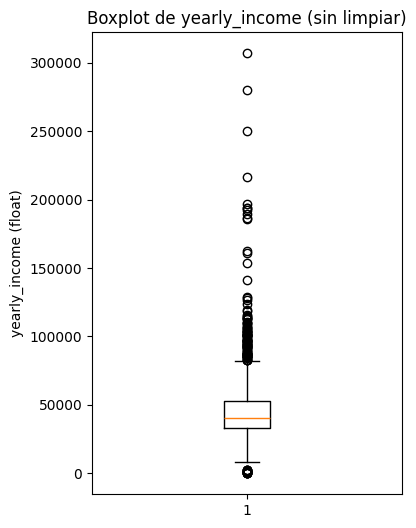

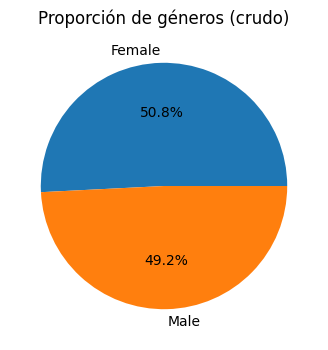

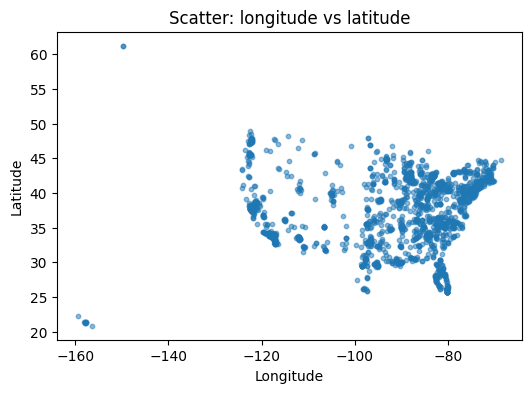

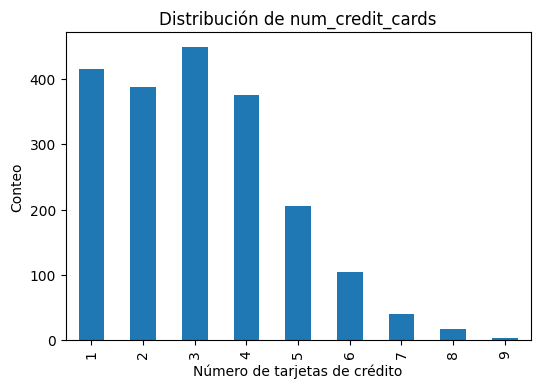

In [12]:

# 3.1 Histograma de 'current_age'
plt.figure(figsize=(6,4))
plt.hist(users_data["current_age"].dropna(), bins=20)
plt.title("Histograma de current_age")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

# 3.2 Boxplot de 'yearly_income' (sin limpiar)
raw_yearly = (
    users_data["yearly_income"]
    .astype(str)
    .str.replace(r"[^\d\.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)
plt.figure(figsize=(4,6))
plt.boxplot(raw_yearly.dropna())
plt.title("Boxplot de yearly_income (sin limpiar)")
plt.ylabel("yearly_income (float)")
plt.show()

# 3.3 Pie chart de 'gender' (crudo)
plt.figure(figsize=(4,4))
users_data["gender"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", labels=["Female","Male"]
)
plt.title("Proporción de géneros (crudo)")
plt.ylabel("")
plt.show()

# 3.4 Scatter de latitud vs longitud
plt.figure(figsize=(6,4))
plt.scatter(
    users_data["longitude"],
    users_data["latitude"],
    alpha=0.5,
    s=10
)
plt.title("Scatter: longitude vs latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 3.5 Distribution de 'num_credit_cards'
plt.figure(figsize=(6,4))
users_data["num_credit_cards"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de num_credit_cards")
plt.xlabel("Número de tarjetas de crédito")
plt.ylabel("Conteo")
plt.show()

# ------------------------------------------
# 3. Limpieza de los datos users_data
# ------------------------------------------

In [13]:
# 3.1) Renombrar 'id' a 'client_id'
users_data = users_data.rename(columns={"id": "client_id"})

# 3.2) Mapear 'gender' a binario (0=Female, 1=Male)
users_data["gender"] = users_data["gender"].str.strip().str.lower().map({"female": 0, "male": 1})

# 3.3) Convertir montos a float: 'per_capita_income', 'yearly_income', 'total_debt'
for col in ["per_capita_income", "yearly_income", "total_debt"]:
    users_data[col] = (
        users_data[col]
        .astype(str)
        .str.replace(r"[^\d\.]", "", regex=True)  # quita todo excepto dígitos y punto
        .replace("", np.nan)
        .astype(float)
    )

# 3.4) Normalizar 'address' (minúsculas, sin acentos)
def normalize_text(col):
    col = col.str.lower().str.strip()
    return col.apply(
        lambda x: unicodedata.normalize("NFKD", x)
                    .encode("ascii", errors="ignore")
                    .decode("utf-8")
        if isinstance(x, str) else x
    )

users_data["address"] = normalize_text(users_data["address"].astype(str))

# 3.5) Crear 'birth_date' a partir de 'birth_year' y 'birth_month'
users_data["birth_date"] = pd.to_datetime(
    users_data["birth_year"].astype(str) + "-" +
    users_data["birth_month"].astype(str).str.zfill(2) + "-01",
    format="%Y-%m-%d",
    errors="coerce"
)

# 3.6) Imputar 'total_debt' faltante con 0 (opcional)
users_data["total_debt"] = users_data["total_debt"].fillna(0)

# 3.7) Crear variable 'age_group' a partir de 'current_age'
bins = [0, 30, 50, 70, 100]
labels = ["<30", "30-50", "50-70", "70+"]
users_data["age_group"] = pd.cut(users_data["current_age"], bins=bins, labels=labels)

# 3.8) One-Hot Encoding de 'age_group'
users_encoded = pd.get_dummies(
    users_data,
    columns=["age_group"],
    drop_first=True
)

# 3.9) Verificar nulos y tipos tras limpieza/codificación
print("Nulos en users_encoded tras limpieza:")
display(users_encoded.isnull().sum())
print("\nTipos en users_encoded tras limpieza:")
display(users_encoded.dtypes)


Nulos en users_encoded tras limpieza:


client_id            0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
birth_date           0
age_group_30-50      0
age_group_50-70      0
age_group_70+        0
dtype: int64


Tipos en users_encoded tras limpieza:


client_id                     int64
current_age                   int64
retirement_age                int64
birth_year                    int64
birth_month                   int64
gender                        int64
address                      object
latitude                    float64
longitude                   float64
per_capita_income           float64
yearly_income               float64
total_debt                  float64
credit_score                  int64
num_credit_cards              int64
birth_date           datetime64[ns]
age_group_30-50                bool
age_group_50-70                bool
age_group_70+                  bool
dtype: object

In [14]:
#Se valida que los json ya esten como dataframes
print(mcc_codes_df["mcc"].dtype)   
print(mcc_codes_df["mcc"].isnull().sum())        # debería dar 0
print(mcc_codes_df.duplicated(subset=["mcc"]).sum())  # debería dar 0

print(fraud_labels_df["id"].dtype)
print(fraud_labels_df["is_fraud"].unique())       # debería dar array([0,1])
print(fraud_labels_df.duplicated(subset=["id"]).sum())  # debería dar 0



int64
0
0
int64
[0 1]
0


In [15]:
# 4.1) Asegurarnos de que 'card_id' sea object en ambos DataFrames
transactions_encoded["card_id"] = transactions_encoded["card_id"].astype(str)
cards_encoded["card_id"]        = cards_encoded["card_id"].astype(str)

# 4.2) Asegurarnos de que 'client_id' sea object en ambos DataFrames
transactions_encoded["client_id"] = transactions_encoded["client_id"].astype(str)
users_encoded["client_id"]        = users_encoded["client_id"].astype(str)

# 4.3) Asegurarnos de que 'mcc' sea object en ambos DataFrames
transactions_encoded["mcc"] = transactions_encoded["mcc"].astype(str)
mcc_codes_df["mcc"]        = mcc_codes_df["mcc"].astype(str)

# 4.4) Asegurarnos de que 'id' sea object en ambos DataFrames para el merge con fraude
transactions_encoded["id"]       = transactions_encoded["id"].astype(str)
fraud_labels_df["id"]            = fraud_labels_df["id"].astype(str)

# 4.5) Verificar tipos impresos
print("Transacciones   → card_id:", transactions_encoded["card_id"].dtype)
print("Tarjetas        → card_id:", cards_encoded["card_id"].dtype)
print()
print("Transacciones   → client_id:", transactions_encoded["client_id"].dtype)
print("Usuarios        → client_id:", users_encoded["client_id"].dtype)
print()
print("Transacciones   → mcc:", transactions_encoded["mcc"].dtype)
print("MCC codes       → mcc:", mcc_codes_df["mcc"].dtype)
print()
print("Transacciones   → id:", transactions_encoded["id"].dtype)
print("Fraude labels   → id:", fraud_labels_df["id"].dtype)


Transacciones   → card_id: object
Tarjetas        → card_id: object

Transacciones   → client_id: object
Usuarios        → client_id: object

Transacciones   → mcc: object
MCC codes       → mcc: object

Transacciones   → id: object
Fraude labels   → id: object


Columnas de tx_cards:


NameError: name 'tx_cards' is not defined

In [ ]:
# ==============================
# ESTRATEGIA: TRABAJAR SÓLO CON LAS PRIMERAS 10 MILLONES DE FILAS
# ==============================

# Partimos de que ya tenemos:
#  - transactions_encoded   (~13 305 915 filas, muchas columnas)
#  - cards_encoded          (~6 146 filas, muchas columnas)
#  - users_encoded          (~2 000 filas, varias columnas)
#  - fraud_labels_df        (~13 305 915 filas, ['id','is_fraud'])
#  - mcc_codes_df           (< 1 000 filas, ['mcc','mcc_description'])

# La idea es reducir “transactions_encoded” a las primeras 10 000 000 filas antes de hacer el merge,
# de modo que al unirlo con los demás DataFrames quepan dentro de 16 GB de RAM.

# --------------------------------------
# 1) REDUCIR “transactions_encoded” A 10 000 000 FILAS
# --------------------------------------
# Seleccionamos únicamente las primeras 10 millones de filas
transactions_10m = transactions_encoded.iloc[:10_000_000].copy()
print("Ahora transactions_10m.shape =", transactions_10m.shape)

# Para asegurarnos de no tener objetos muy pesados, podemos recortar columnas innecesarias.
# Por ejemplo, quedarnos sólo con:
#   - llaves:    'id', 'date', 'client_id', 'card_id', 'mcc'
#   - numéricas: 'amount', 'trans_hour', 'trans_day', 'trans_month', 'trans_weekday'
#   - One-Hot:   todas las columnas que empiecen con 'use_chip_' y 'merchant_state_'
#
# Ajusta según lo que realmente necesites en tu análisis/modelo.

tx_base_cols = [
    "id",
    "date",
    "client_id",
    "card_id",
    "amount",
    "mcc",
    "trans_hour",
    "trans_day",
    "trans_month",
    "trans_weekday",
]
use_chip_cols       = [c for c in transactions_10m.columns if c.startswith("use_chip_")]
merchant_state_cols = [c for c in transactions_10m.columns if c.startswith("merchant_state_")]
tx_needed_cols      = tx_base_cols + use_chip_cols + merchant_state_cols

# Creamos un DataFrame más “delgado” con sólo esas columnas
transactions_10m = transactions_10m[tx_needed_cols].copy()
print("Después de recortar columnas, transactions_10m.shape =", transactions_10m.shape)

# Convertir a 'category' las columnas object de cardinalidad moderada (evita inflar RAM)
for c in transactions_10m.select_dtypes(include="object").columns:
    if c not in ["date", "id", "client_id", "card_id", "mcc"]:
        transactions_10m[c] = transactions_10m[c].astype("category")

# Asegurarnos de que las llaves estén en tipo string
transactions_10m["id"]         = transactions_10m["id"].astype(str)
transactions_10m["client_id"]  = transactions_10m["client_id"].astype(str)
transactions_10m["card_id"]    = transactions_10m["card_id"].astype(str)
transactions_10m["mcc"]        = transactions_10m["mcc"].astype(str)

# --------------------------------------
# 2) REDUCIR “cards_encoded” Y “users_encoded” A COLUMNAS ESENCIALES
# --------------------------------------
# Para ahorrar RAM, extraemos sólo las columnas necesarias de cards_encoded y users_encoded.

# Ejemplo: en cards_encoded sólo necesitamos:
#  - 'card_id', 'credit_limit', 'has_chip' + dummies de card_brand que usemos
cards_cols_needed = ["card_id", "credit_limit", "has_chip"]
# Si utilizas dummies de card_brand, agrégalas así:
# cards_cols_needed += ["card_brand_visa", "card_brand_mastercard", ...]
cards_cols_needed = [c for c in cards_cols_needed if c in cards_encoded.columns]
cards_trimmed = cards_encoded[cards_cols_needed + ["client_id"]].copy()
for c in cards_trimmed.select_dtypes(include="object").columns:
    if c not in ["card_id", "client_id"]:
        cards_trimmed[c] = cards_trimmed[c].astype("category")
cards_trimmed["card_id"]   = cards_trimmed["card_id"].astype(str)
cards_trimmed["client_id"] = cards_trimmed["client_id"].astype(str)
print("cards_trimmed.shape =", cards_trimmed.shape)

# En users_encoded sólo necesitamos:
#  - 'client_id', 'current_age', 'gender', 'yearly_income'
#  - (y los dummies de age_group que uses, p.ej. 'age_group_30-50', etc.)
users_cols_needed = ["client_id", "current_age", "gender", "yearly_income"]
users_cols_needed = [c for c in users_cols_needed if c in users_encoded.columns]
users_trimmed = users_encoded[users_cols_needed].copy()
for c in users_trimmed.select_dtypes(include="object").columns:
    if c != "client_id":
        users_trimmed[c] = users_trimmed[c].astype("category")
users_trimmed["client_id"] = users_trimmed["client_id"].astype(str)
print("users_trimmed.shape =", users_trimmed.shape)

# --------------------------------------
# 3) MERGE 1: transactions_10m + cards_trimmed POR 'card_id'
# --------------------------------------
tx_cards_10m = transactions_10m.merge(
    cards_trimmed,
    on="card_id",
    how="left"
)
print("\ntx_cards_10m.shape =", tx_cards_10m.shape)

# Verificar algunos nulos en las columnas de cards_trimmed
print("\nValores nulos en columnas de cards_trimmed en tx_cards_10m:")
for col in cards_trimmed.columns:
    if col != "card_id":
        n_null = tx_cards_10m[col].isnull().sum()
        if n_null > 0:
            print(f"  {col}: {n_null} nulos")

# --------------------------------------
# 4) MERGE 2: tx_cards_10m + users_trimmed POR 'client_id'
# --------------------------------------
tx_cards_users_10m = tx_cards_10m.merge(
    users_trimmed,
    on="client_id",
    how="left"
)
print("\ntx_cards_users_10m.shape =", tx_cards_users_10m.shape)

# Verificar nulos en las columnas de users_trimmed
print("\nValores nulos en columnas de users_trimmed en tx_cards_users_10m:")
for col in users_trimmed.columns:
    if col != "client_id":
        n_null = tx_cards_users_10m[col].isnull().sum()
        if n_null > 0:
            print(f"  {col}: {n_null} nulos")

# --------------------------------------
# 5) MERGE 3: tx_cards_users_10m + fraud_labels_df POR 'id'
# --------------------------------------
# Asegurar que 'id' sea string en ambos
tx_cards_users_10m["id"]           = tx_cards_users_10m["id"].astype(str)
fraud_labels_df["id"]              = fraud_labels_df["id"].astype(str)

tx_cards_users_labels_10m = tx_cards_users_10m.merge(
    fraud_labels_df,
    on="id",
    how="left"
)
print("\ntx_cards_users_labels_10m.shape =", tx_cards_users_labels_10m.shape)
print("Transacciones sin etiqueta de fraude:",
      tx_cards_users_labels_10m["is_fraud"].isnull().sum(), "de", len(tx_cards_users_labels_10m))

# Rellenar NaN en is_fraud con 0
tx_cards_users_labels_10m["is_fraud"] = tx_cards_users_labels_10m["is_fraud"].fillna(0).astype(int)

# --------------------------------------
# 6) MERGE 4: tx_cards_users_labels_10m + mcc_codes_df POR 'mcc'
# --------------------------------------
tx_cards_users_labels_10m["mcc"]   = tx_cards_users_labels_10m["mcc"].astype(str)
mcc_codes_df["mcc"]               = mcc_codes_df["mcc"].astype(str)

full_10m = tx_cards_users_labels_10m.merge(
    mcc_codes_df,
    on="mcc",
    how="left"
)
print("\nfull_10m.shape =", full_10m.shape)
print("Transacciones sin descripción de MCC:",
      full_10m["mcc_description"].isnull().sum(), "de", len(full_10m))

# Rellenar NaN en mcc_description con "unknown"
full_10m["mcc_description"] = full_10m["mcc_description"].fillna("unknown")

# --------------------------------------
# 7) REVISIÓN FINAL DE TIPOS Y NULOS
# --------------------------------------
print("\n--- Tipos de datos en full_10m (primeras 10 columnas) ---")
print(full_10m.dtypes.head(10))

print("\n--- Conteo de nulos en columnas clave ---")
for col in ["id", "date", "card_id", "client_id",
            "amount", "credit_limit",
            "current_age", "yearly_income",
            "is_fraud", "mcc_description"]:
    n_null = full_10m[col].isnull().sum()
    print(f"  {col}: {n_null} nulos")

# --------------------------------------
# 8) GUARDAR RESULTADO EN PARQUET
# --------------------------------------
full_10m.to_parquet("full_transactions_10m.parquet", index=False)
print("\n¡Dataset final (10M filas) guardado como 'full_transactions_10m.parquet'!")


Ahora transactions_10m.shape = (10000000, 215)
Después de recortar columnas, transactions_10m.shape = (10000000, 211)
